# One Example
On 2025-08-26, the new 2025-2026 school year to welcome students to University of California at Merced, it started raining at around 9 am and it lasted around 3 hours. Considering this day as a special day, we will get ground observations for evapotranspiration calculation, which will be explained below.<br>
Three locations will be used. Two of them come from CIMIS stations, which are called Denair II and Fresno State, respectively. Another one comes from the smart farm at University of California, Merced.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from Functions.eto_cimis import eto_cimis
# from Functions.eto_pm import eto_hourly_fao56_asce_row
# from Functions.eto_pm import compute_eto_hourly_and_daily

from Functions.eto_pm_1 import eto_hourly_fao56_asce_row
from Functions.eto_pm_1 import compute_eto_hourly_and_daily

In [2]:
cimis_denair2 = Path("Inputs") / "CIMIS_DenairII_20250826.csv"
cimis_denair2 = pd.read_csv(cimis_denair2)

## CIMIS ETo
ETo calculation using CIMIS method based on local observations from the eddy-covariance flux tower

In [3]:
# 1) Load the Excel file which is obtained from the eddy-covariance flux tower (only one day with raining event)
input_path = Path("Inputs") / "ec_part_data.xlsx"
df_raw = pd.read_excel(input_path)

# 2) Parse TIMESTAMP_START into datetime (YYYYMMDDHHMM)
df_raw['time'] = pd.to_datetime(df_raw['TIMESTAMP_START'].astype(str), format='%Y%m%d%H%M')

# 3) Rename columns to standardized names
df = df_raw.rename(columns={
    'TA': 'T_C',      # Air temperature in °C
    'RH': 'RH_pct',   # Relative humidity in %
    'Rn': 'Rn_Wm2',   # Net radiation in W/m²
    'WS': 'U2_ms',     # Wind speed at 2 meters in m/s
    'ET': 'ET_mm',    # Observed ET in mm
    'P': 'P_mm',     # Precipitation in mm
    'TS': 'Surface_Temp_C',  # Surface temperature via Apogee IRT in °C
})

# 4) Ensure numeric types
for col in ['T_C', 'RH_pct', 'Rn_Wm2', 'U2_ms', 'ET_mm', 'P_mm', 'Surface_Temp_C']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 5) Compute saturation vapor pressure (es) and actual vapor pressure (ea)
T = df['T_C']
RH = df['RH_pct']
es = 0.6108 * np.exp((17.27 * T) / (237.3 + T))    # Saturation vapor pressure (kPa)
df['ea_kPa'] = (RH / 100.0) * es                   # Actual vapor pressure (kPa)

# 6) Add elevation, this needs to be set based on the flux tower location
Z_m = 63.4
df['Z_m'] = Z_m

# 7) Set datetime index
df = df.set_index('time').sort_index()

# 8) Preview
df[['T_C', 'RH_pct', 'Rn_Wm2', 'U2_ms', 'ea_kPa', 'ET_mm', 'P_mm', 'Surface_Temp_C']].head()

,T_C,RH_pct,Rn_Wm2,U2_ms,ea_kPa,ET_mm,P_mm,Surface_Temp_C
time,,,,,,,,
2025-08-26 00:00:00,25.70642,38.23991,-53.98228,4.078015,1.263272,0.047995,0.0,24.0395
2025-08-26 00:30:00,25.24659,37.80269,-52.56641,3.116852,1.215207,0.032136,0.0,22.0736
2025-08-26 01:00:00,24.38638,39.28114,-47.92889,1.314048,1.199576,0.017346,0.0,20.9293
2025-08-26 01:30:00,23.38737,41.06036,-43.46173,1.188681,1.180871,0.004544,0.0,21.5678
2025-08-26 02:00:00,23.68952,38.53232,-49.03622,3.178008,1.128519,0.033060,0.0,22.2298


In [4]:
# Call the CIMIS ETo function
# Net radiation is provided by the flux tower directly,
# so we use Rn (Wm-2) directly instead of calculating it from solar radiation which contains more variables.
df_hourly_cimis, eto_daily_cimis = eto_cimis(
    T_C=df['T_C'].values,
    ea_kPa=df['ea_kPa'].values,
    Rn_Wm2=df['Rn_Wm2'].values,
    U2_ms=df['U2_ms'].values,
    Z_m=Z_m,
    time_index=df.index
)
df_hourly_cimis['ET_mm'] = df['ET_mm']
df_hourly_cimis['P_mm'] = df['P_mm']
df_hourly_cimis['Surface_Temp_C'] = df['Surface_Temp_C']

# Hourly RET with components
# display(df_hourly_cimis)
df_hourly_cimis.head(3)

,T_C,ea_kPa,Rn_Wm2,U2_ms,RET_mm_hr,es_kPa,VPD_kPa,Delta_kPa_per_C,P_kPa,gamma_kPa_per_C,W,NR_mm_hr,FU2,ET_mm,P_mm,Surface_Temp_C
time,,,,,,,,,,,,,,,,
2025-08-26 00:00:00,25.70642,1.263272,-53.98228,4.078015,0.155143,3.303543,2.040271,0.195713,100.573087,0.066550,0.746246,-0.003027,0.304025,0.047995,0.0,24.0395
2025-08-26 00:30:00,25.24659,1.215207,-52.56641,3.116852,0.132944,3.214606,1.999398,0.191112,100.573087,0.066522,0.741796,-0.003001,0.261830,0.032136,0.0,22.0736
2025-08-26 01:00:00,24.38638,1.199576,-47.92889,1.314048,0.088270,3.053823,1.854246,0.182748,100.573087,0.066469,0.733289,-0.002833,0.182687,0.017346,0.0,20.9293


## PM method for ETo

In [5]:
# ---- Run it (short reference grass by default) ----
df_hourly_pm_short, eto_daily_pm_short = compute_eto_hourly_and_daily(df_hourly_cimis, reference="short")

# Inspect:
df_hourly_pm_short[['PM-ETo_hourly_mm']].head()
eto_daily_pm_short

time
2025-08-26    10.151603
Freq: D, Name: PM-ETo_daily_mm, dtype: float64

In [6]:
df_hourly_pm_tall, eto_daily_pm_tall = compute_eto_hourly_and_daily(df_hourly_cimis, reference="tall")

# Inspect:
df_hourly_pm_tall[['PM-ETo_hourly_mm']].head()
eto_daily_pm_tall

time
2025-08-26    14.064384
Freq: D, Name: PM-ETo_daily_mm, dtype: float64

In [7]:
df_hourly_cimis['CIMIS-ETo'] = df_hourly_cimis['RET_mm_hr']
df_hourly_cimis['PM-ETo-Short'] = df_hourly_pm_short['PM-ETo_hourly_mm']
df_hourly_cimis['PM-ETo-Tall'] = df_hourly_pm_tall['PM-ETo_hourly_mm']

In [8]:
display(df_hourly_cimis)

,T_C,ea_kPa,Rn_Wm2,U2_ms,RET_mm_hr,es_kPa,VPD_kPa,Delta_kPa_per_C,P_kPa,gamma_kPa_per_C,W,NR_mm_hr,FU2,ET_mm,P_mm,Surface_Temp_C,CIMIS-ETo,PM-ETo-Short,PM-ETo-Tall
time,,,,,,,,,,,,,,,,,,,
2025-08-26 00:00:00,25.70642,1.263272,-53.982280,4.078015,0.155143,3.303543,2.040271,0.195713,100.573087,0.066550,0.746246,-0.003027,0.304025,0.047995,0.0,24.0395,0.155143,0.116351,0.151915
2025-08-26 00:30:00,25.24659,1.215207,-52.566410,3.116852,0.132944,3.214606,1.999398,0.191112,100.573087,0.066522,0.741796,-0.003001,0.261830,0.032136,0.0,22.0736,0.132944,0.096459,0.131015
2025-08-26 01:00:00,24.38638,1.199576,-47.928890,1.314048,0.088270,3.053823,1.854246,0.182748,100.573087,0.066469,0.733289,-0.002833,0.182687,0.017346,0.0,20.9293,0.088270,0.041186,0.064499
2025-08-26 01:30:00,23.38737,1.180871,-43.461730,1.188681,0.081224,2.875939,1.695068,0.173425,100.573087,0.066408,0.723108,-0.002678,0.177183,0.004544,0.0,21.5678,0.081224,0.035386,0.055983
2025-08-26 02:00:00,23.68952,1.128519,-49.036220,3.178008,0.128204,2.928760,1.800241,0.176202,100.573087,0.066426,0.726222,-0.002983,0.264515,0.033060,0.0,22.2298,0.128204,0.092185,0.123671
2025-08-26 02:30:00,23.74666,1.048573,-43.628390,2.070471,0.109565,2.938844,1.890271,0.176731,100.573087,0.066430,0.726807,-0.002648,0.215894,0.026878,0.0,20.8459,0.109565,0.071307,0.102236
2025-08-26 03:00:00,22.44057,1.032160,-35.581750,1.579799,0.092228,2.715768,1.683608,0.164962,100.573087,0.066349,0.713160,-0.002285,0.194353,0.012245,0.0,21.1944,0.092228,0.053595,0.079429
2025-08-26 03:30:00,21.84664,1.087581,-35.059990,1.299294,0.080128,2.619318,1.531737,0.159834,100.573087,0.066313,0.706770,-0.002313,0.182039,0.005519,0.0,20.7282,0.080128,0.040296,0.061610
2025-08-26 04:00:00,21.27213,1.156894,-39.187190,1.534317,0.077187,2.528882,1.371988,0.155002,100.573087,0.066278,0.700480,-0.002655,0.192357,0.003544,0.0,20.3600,0.077187,0.041020,0.061281


In [9]:
# Daily ETo totals (mm/day)
print("PM method:")
display(eto_daily_cimis)
print("PM method, short grass:")
display(eto_daily_pm_short)
print("PM method, tall alfalfa:")
display(eto_daily_pm_tall)

PM method:


time
2025-08-26    5.398435
Freq: D, Name: ETo_mm_day, dtype: float64

PM method, short grass:


time
2025-08-26    10.151603
Freq: D, Name: PM-ETo_daily_mm, dtype: float64

PM method, tall alfalfa:


time
2025-08-26    14.064384
Freq: D, Name: PM-ETo_daily_mm, dtype: float64

In [10]:
# # 5) Save outputs
# out_dir = Path("outputs")
# out_dir.mkdir(exist_ok=True)
# df_hourly.to_csv(out_dir / "hourly_components_and_RET.csv")
# eto_daily.to_csv(out_dir / "daily_ETo.csv", header=True)
# print("Saved:", out_dir / "hourly_components_and_RET.csv")
# print("Saved:", out_dir / "daily_ETo.csv")

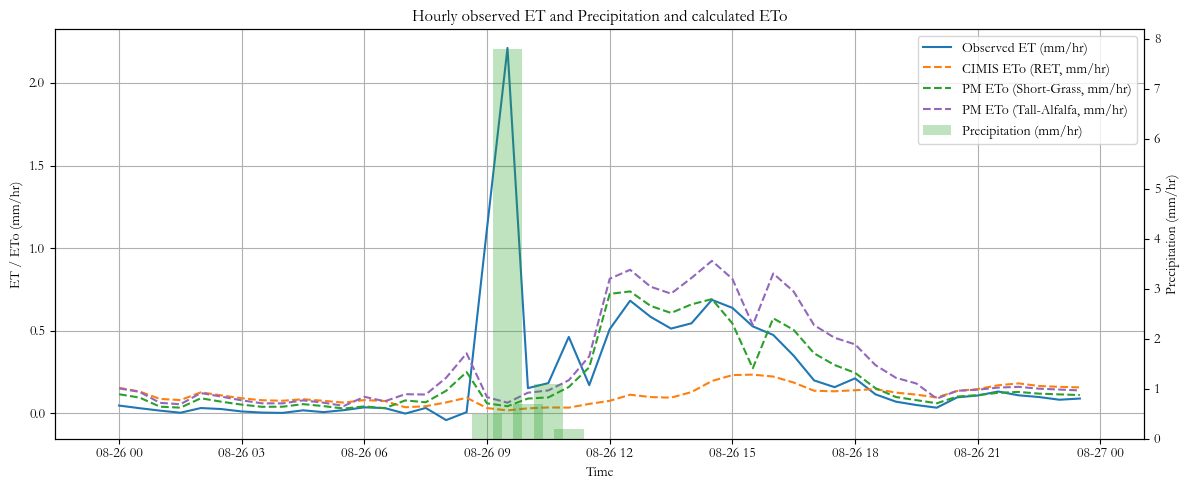

In [11]:
import matplotlib.pyplot as plt

# Set Garamond font globally
plt.rcParams['font.family'] = 'Garamond'

# Merge relevant columns into a single DataFrame for plotting
df_plot = df_hourly_cimis.copy()

# Drop rows where any of the three are missing
df_plot = df_plot[['CIMIS-ETo', 'PM-ETo-Short', 'PM-ETo-Tall', 'ET_mm', 'P_mm']].dropna()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot ET and ETo on primary y-axis
ax1.plot(df_plot.index, df_plot['ET_mm'], label='Observed ET (mm/hr)', color='tab:blue', linewidth=1.5)
ax1.plot(df_plot.index, df_plot['CIMIS-ETo'], label='CIMIS ETo (RET, mm/hr)', color='tab:orange', linestyle='--', linewidth=1.5)
ax1.plot(df_plot.index, df_plot['PM-ETo-Short'], label='PM ETo (Short-Grass, mm/hr)', color='tab:green', linestyle='--', linewidth=1.5)
ax1.plot(df_plot.index, df_plot['PM-ETo-Tall'], label='PM ETo (Tall-Alfalfa, mm/hr)', color='tab:purple', linestyle='--', linewidth=1.5)
ax1.set_ylabel("ET / ETo (mm/hr)")
ax1.set_xlabel("Time")
ax1.grid(True)

# Create secondary y-axis for precipitation
ax2 = ax1.twinx()
ax2.bar(df_plot.index, df_plot['P_mm'], width=0.03, label='Precipitation (mm/hr)', color='tab:green', alpha=0.3)
ax2.set_ylabel("Precipitation (mm/hr)")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Final layout
plt.title("Hourly observed ET and Precipitation and calculated ETo")
plt.tight_layout()
plt.savefig("20280826.png", dpi=600)
plt.show()

## Hargreaves-Samani ETo
Using the same data for Hargreaves-Samani ETo calculation

In [12]:
from Functions.solar_radiation import solar_radiation
from Functions.doy import doy
from Functions.eto_hargreaves_samani import eto_hargreaves_samani

latitude_deg = 37.355249
[Year, Month, Day] = [2025, 8, 26]
DOY = doy(Year,Month,Day)
Ra = solar_radiation(latitude_deg, DOY, Year, "YES")

df_daily_temp = df_hourly_cimis.resample("D").agg(
    Tmax=('T_C', 'max'),
    Tmin=('T_C', 'min'),
    Tmean=('T_C', 'mean')
).dropna()
display(df_daily_temp)
eto_HS = eto_hargreaves_samani(df_daily_temp['Tmax'], df_daily_temp['Tmin'], Tmean=df_daily_temp['Tmean'], Ra=Ra)

This year contains: 365 days.
The declination of the sun is: 0.174
The relative distance from the earth to the sun is: 0.9809
The sunset hour angle in decimal value is: 0.5864
The solar radiation at the location is: 18.2501


,Tmax,Tmin,Tmean
time,,,
2025-08-26,35.61629,20.06542,25.923231


# Summary

In [13]:
digital_num = 1

print("On",df_daily_temp.index[0].date(),"\n")
print('CIMIS method ETo:')
print(round(eto_daily.iloc[-1], digital_num), "mm/day")
print('Hargreaves-Samani method ETo:')
print(eto_HS[0].round(digital_num), "mm/day")
print("EC-Flux tower observed ET:")
print(round(df_hourly['ET_mm'].sum(), digital_num), "mm/day")

On 2025-08-26 

CIMIS method ETo:


NameError: name 'eto_daily' is not defined